In [54]:
import glob
import os.path as op
from nilearn import image
from nilearn.masking import apply_mask
import numpy as np
import pandas as pd

In [55]:
derivatives = '/data/odc/derivatives'

In [56]:
def get_tsnr_over_depth(subject, session):
    v1_l = op.join(derivatives, 'pycortex', 'masks', f'sub-{subject}', f'sub-{subject}_desc-V1l_gm_mask.nii.gz')
    v1_r = op.join(derivatives, 'pycortex', 'masks', f'sub-{subject}', f'sub-{subject}_desc-V1r_gm_mask.nii.gz')

    depth_l = op.join(derivatives, 'nighres', f'sub-{subject}', 'ses-anat', 'anat', f'sub-{subject}_ses-anat_space-average_desc-layerdepth_hemi-left_depth.nii.gz')
    depth_r = op.join(derivatives, 'nighres', f'sub-{subject}', 'ses-anat', 'anat', f'sub-{subject}_ses-anat_space-average_desc-layerdepth_hemi-right_depth.nii.gz')

    depth_l = apply_mask(depth_l, v1_l)
    depth_r = apply_mask(depth_r, v1_r)
    
    columns_l = pd.MultiIndex.from_arrays([np.arange(len(depth_l)), depth_l], names=['voxel', 'depth'])
    columns_r = pd.MultiIndex.from_arrays([np.arange(len(depth_r)), depth_r], names=['voxel', 'depth'])
    
    tsnr_filenames = glob.glob(op.join(derivatives, 'tsnr', f'sub-{subject}', f'ses-{session}', 'func', f'sub-{subject}_ses-{session}_task-*_acq-07_run-*_tsnr.nii.gz'))
    tsnr = [image.resample_to_img(t, v1_l, interpolation='nearest') for t in tsnr_filenames]    
    
    tsnr_l = apply_mask(tsnr, v1_l)
    tsnr_l = pd.DataFrame(tsnr_l, index=tsnr_filenames, columns=columns_l)

    tsnr_r = apply_mask(tsnr, v1_r)
    tsnr_r = pd.DataFrame(tsnr_r, index=tsnr_filenames, columns=columns_r)
    
    return tsnr_l, tsnr_r

In [57]:
for subject, session in [('bm', 'odc'), ('de', 'odc1'), ('eo', 'odc'), ('ms', 'odc2'), ('tk', 'odc2'), ('tk', 'odc3'), ('tr', 'odc')][:3]:
    tsnr_l, tsnr_r = get_tsnr_over_depth(subject, session)
    tsnr = pd.concat((tsnr_l, tsnr_r), keys=['V1_L', 'V1_R'], axis=1, names=['mask'])
    tsnr.to_pickle(op.join(derivatives, 'tsnr', f'sub-{subject}', f'ses-{session}', 'func', f'sub-{subject}_ses-{session}_tsnr.pkl'))

In [58]:
import seaborn as sns

In [59]:
tsnr = []
for subject, session in [('bm', 'odc'), ('de', 'odc1'), ('eo', 'odc'), ('ms', 'odc2'), ('tk', 'odc2'), ('tk', 'odc3'), ('tr', 'odc')]:
    t = pd.read_pickle(op.join(derivatives, 'tsnr', f'sub-{subject}', f'ses-{session}', 'func', f'sub-{subject}_ses-{session}_tsnr.pkl'))
    
    t = t.loc[:, ~(t == 0).any(0)].mean().to_frame('tsnr')
    t['subject'], t['session'] = subject, session
    
    t = t.set_index(['subject', 'session'], append=True).reset_index('depth')    
    t = t.reorder_levels(['subject', 'session', 'mask', 'voxel'])
    
    tsnr.append(t)
    
tsnr = pd.concat(tsnr)

In [60]:
tsnr['depth_bin'] = pd.cut(tsnr['depth'], np.linspace(0, 1, 7), labels=np.round(np.linspace(1/7., 1-1/7., 6), 2))

In [61]:
tsnr = tsnr.drop([('bm', 'odc', 'V1_L')])

/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


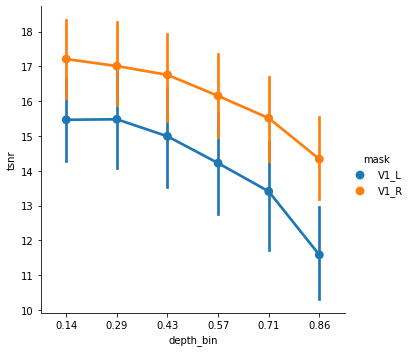

In [62]:
sns.catplot('depth_bin', 'tsnr', 'mask', data=tsnr.reset_index().groupby(['subject', 'mask', 'depth_bin'], as_index=False).mean(), kind='point', ci=67)